In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Dropout, concatenate

from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
dataset = pd.read_csv('../data/TFT_energy.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,price,price_dayahead,gen_coal,gen_gas,load_actual,gen_lig,gen_oil,gen_oth_renew,pressure_Barcelona,pressure_Bilbao,...,wind_deg_Bilbao,clouds_all_Bilbao,gen_hyd_river,wind_deg_Seville,wind_speed_Barcelona,wind_speed_Valencia,wind_speed_Bilbao,gen_wind,wind_speed_Madrid,gen_hyd_pump
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,64.92,48.10,4755.0,5196.0,24382.0,328.0,158.0,71.0,1035.0,1035.0,...,229.0,0.0,1009.0,21.0,7.0,1.0,0.0,5890.0,1.0,920.0
2015-01-01 01:00:00+00:00,64.48,47.33,4581.0,4857.0,22734.0,323.0,157.0,73.0,1036.0,1036.0,...,224.0,0.0,973.0,27.0,7.0,0.0,1.0,5461.0,1.0,1164.0
2015-01-01 02:00:00+00:00,59.32,42.27,4131.0,4314.0,21286.0,254.0,160.0,75.0,1036.0,1035.0,...,225.0,0.0,949.0,27.0,7.0,0.0,1.0,5238.0,1.0,1503.0
2015-01-01 03:00:00+00:00,56.04,38.41,3840.0,4130.0,20264.0,187.0,156.0,74.0,1036.0,1035.0,...,221.0,0.0,953.0,27.0,7.0,0.0,1.0,4935.0,1.0,1826.0
2015-01-01 04:00:00+00:00,53.63,35.72,3590.0,4038.0,19905.0,178.0,156.0,74.0,1037.0,1035.0,...,224.0,0.0,952.0,57.0,5.0,2.0,1.0,4618.0,0.0,2109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,77.02,68.85,2628.0,7634.0,30653.0,0.0,178.0,95.0,1027.0,1033.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0
2018-12-31 19:00:00+00:00,76.16,68.40,2566.0,7241.0,29735.0,0.0,174.0,95.0,1027.0,1034.0,...,0.0,0.0,1172.0,30.0,3.0,1.0,1.0,3288.0,1.0,1.0
2018-12-31 20:00:00+00:00,74.30,66.88,2422.0,7025.0,28071.0,0.0,168.0,94.0,1028.0,1034.0,...,140.0,0.0,1148.0,50.0,4.0,3.0,1.0,3503.0,1.0,50.0


In [4]:
print(dataset.columns)

Index(['price', 'price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['price']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (35063, 1)
stages_supervised.shape: (34968, 96)


In [7]:
stages.max()

price    116.8
dtype: float64

In [8]:
stages_supervised

,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
time,,,,,,,,,,,,,,,,,,,,,
2015-01-04 00:00:00+00:00,64.92,64.48,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,...,52.07,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77
2015-01-04 01:00:00+00:00,64.48,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,59.86,...,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89
2015-01-04 02:00:00+00:00,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,59.86,60.12,...,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91
2015-01-04 03:00:00+00:00,56.04,53.63,51.73,51.43,48.98,54.20,58.94,59.86,60.12,62.05,...,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68
2015-01-04 04:00:00+00:00,53.63,51.73,51.43,48.98,54.20,58.94,59.86,60.12,62.05,62.06,...,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68,58.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-30 19:00:00+00:00,78.99,77.65,73.28,73.48,70.93,68.61,64.19,62.53,59.78,59.82,...,72.12,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02
2018-12-30 20:00:00+00:00,77.65,73.28,73.48,70.93,68.61,64.19,62.53,59.78,59.82,64.27,...,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16
2018-12-30 21:00:00+00:00,73.28,73.48,70.93,68.61,64.19,62.53,59.78,59.82,64.27,66.81,...,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16,74.30


#### Prior unknown covariates (6)

In [9]:
# prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
# print("prior_unknown.shape:", prior_unknown.shape)

# prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, K)
# print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

In [10]:
# prior_unknown_supervised

#### Prior known covariates (9)

In [11]:
prior_known = dataset[['price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, K)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (35063, 25)
prior_known_supervised.shape: (34968, 2400)


In [12]:
# prior_known_supervised

### N_out, N_in, K

In [13]:
past_cov = dataset[['price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump']]

past_cov_supervised = series_to_supervised(past_cov, n_hours, K)
print("past_cov_supervised.shape:", past_cov_supervised.shape)

past_cov_supervised.shape: (34968, 2400)


In [14]:
# past_cov_supervised  # 6 + 9 = 15 features

In [15]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [16]:
# past_ws_supervised  # 4

In [17]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*past_cov.shape[1]:(i+1)*past_cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [18]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised, past_ws_supervised], axis=1)
past_cov_ws_supervised = past_cov_ws_supervised[columns]


In [19]:
# past_cov_ws_supervised

In [20]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, K*prior_known.shape[1]:]  # shift 2 days for prior known covariates
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var10(t-48),...,shift_prior_known_supervised_var16(t+23),shift_prior_known_supervised_var17(t+23),shift_prior_known_supervised_var18(t+23),shift_prior_known_supervised_var19(t+23),shift_prior_known_supervised_var20(t+23),shift_prior_known_supervised_var21(t+23),shift_prior_known_supervised_var22(t+23),shift_prior_known_supervised_var23(t+23),shift_prior_known_supervised_var24(t+23),shift_prior_known_supervised_var25(t+23)
0,7.00,1190.0,2902.0,24935.0,0.0,192.0,61.0,1038.0,1036.0,167.0,...,156.0,21.0,1182.0,132.0,2.0,1.0,0.0,7351.0,1.0,650.0
1,5.00,1023.0,2772.0,23214.0,0.0,189.0,60.0,1037.0,1036.0,167.0,...,163.0,12.0,1099.0,132.0,1.0,1.0,0.0,7403.0,1.0,938.0
2,4.00,1016.0,2936.0,22540.0,0.0,188.0,59.0,1037.0,1036.0,181.0,...,160.0,13.0,1076.0,108.0,2.0,2.0,0.0,7887.0,1.0,1021.0
3,4.00,1103.0,2893.0,22096.0,0.0,189.0,61.0,1037.0,1037.0,181.0,...,165.0,6.0,982.0,108.0,1.0,2.0,0.0,8348.0,1.0,2067.0
4,4.80,1120.0,2889.0,22066.0,0.0,190.0,59.0,1038.0,1037.0,171.0,...,162.0,20.0,982.0,108.0,1.0,2.0,0.0,8348.0,1.0,2067.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34963,66.00,2931.0,9149.0,32642.0,718.0,294.0,103.0,1028.0,1033.0,314.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0
34964,62.09,2889.0,8024.0,32155.0,675.0,294.0,103.0,1028.0,1033.0,315.0,...,0.0,0.0,1172.0,30.0,3.0,1.0,1.0,3288.0,1.0,1.0
34965,61.77,2871.0,6871.0,30428.0,569.0,291.0,104.0,1029.0,1033.0,314.0,...,140.0,0.0,1148.0,50.0,4.0,3.0,1.0,3503.0,1.0,50.0
34966,58.43,2619.0,5822.0,28015.0,310.0,288.0,103.0,1029.0,1033.0,313.0,...,120.0,0.0,1128.0,60.0,5.0,2.0,1.0,3586.0,2.0,108.0


In [21]:
shift_prior_known_past_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
                                                     axis=1)


In [22]:
# shift_prior_known_past_cov_ws_supervised

In [23]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
0,50.54,48.68,48.02,47.06,46.79,47.63,47.44,50.84,54.84,59.95,...,52.07,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77
1,48.68,48.02,47.06,46.79,47.63,47.44,50.84,54.84,59.95,59.35,...,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89
2,48.02,47.06,46.79,47.63,47.44,50.84,54.84,59.95,59.35,57.03,...,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91
3,47.06,46.79,47.63,47.44,50.84,54.84,59.95,59.35,57.03,59.22,...,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68
4,46.79,47.63,47.44,50.84,54.84,59.95,59.35,57.03,59.22,58.56,...,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68,58.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34963,73.35,73.64,71.92,69.49,68.40,60.32,57.73,57.66,57.04,57.48,...,72.12,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02
34964,73.64,71.92,69.49,68.40,60.32,57.73,57.66,57.04,57.48,61.13,...,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16
34965,71.92,69.49,68.40,60.32,57.73,57.66,57.04,57.48,61.13,60.70,...,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16,74.30
34966,69.49,68.40,60.32,57.73,57.66,57.04,57.48,61.13,60.70,66.64,...,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16,74.30,69.89


### Concatenation

In [24]:
all_data = concat([shift_prior_known_past_cov_ws_supervised, future_ws_supervised], axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (34968, 3696)


### Train & Test set

In [25]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 27974


In [26]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

3672

### Normalization

In [27]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (27974, 3672) (27974, 24) (6994, 3672) (6994, 24)


In [28]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (27974, 72, 51) (27974, 24) (6994, 72, 51) (6994, 24)


### Model

In [30]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))

# 4 cnn with skip connection
x1 = layers.Conv1D(filters=256, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)

x1_merge1 = concatenate([model_input, x1])

x1 = layers.Conv1D(filters=128, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge1)

x1_merge2 = concatenate([model_input, x1])

x1 = layers.Conv1D(filters=64, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge2)

x1_merge3 = concatenate([model_input, x1])

x1 = layers.Conv1D(filters=32, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge3)


# 4 rnn with skip connection
x2 = layers.SimpleRNN(128, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)
x2_merge1 = concatenate([model_input, x2])

x2 = layers.SimpleRNN(64, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge1)

x2_merge2 = concatenate([model_input, x2])

x2 = layers.SimpleRNN(32, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge2)

x2_merge3 = concatenate([model_input, x2])

x2 = layers.SimpleRNN(16, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge3)


merge = concatenate([model_input, x1, x2])
merge = layers.Flatten()(merge)
x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(merge)
x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = Dense(train_y.shape[1])(x)

energy_pararcnn = Model(model_input, x)
energy_pararcnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 72, 51)]     0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 72, 256)      26368       input_2[0][0]                    
__________________________________________________________________________________________________
simple_rnn_4 (SimpleRNN)        (None, 72, 128)      23040       input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 72, 307)      0           input_2[0][0]                    
                                                                 conv1d_4[0][0]             

Epoch 1/6000


2023-01-06 23:29:33.865666: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-01-06 23:29:34.455785: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-01-06 23:29:35.652590: E tensorflow/stream_executor/gpu/asm_compiler.cc:110] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 9.2.88).  Compilation of XLA kernels below will likely fail.

You do not need to update CUDA; cherry-picking the ptxas binary is sufficient.
2023-01-06 23:29:36.027819: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 65280, output: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.



Epoch 00001: val_mae improved from inf to 0.18143, saving model to saved_model/energy_pararcnn_sc1_4layer_24h.h5
55/55 - 52s - loss: 0.3852 - mae: 0.1315 - val_loss: 0.3328 - val_mae: 0.1814
Epoch 2/6000

Epoch 00002: val_mae improved from 0.18143 to 0.10337, saving model to saved_model/energy_pararcnn_sc1_4layer_24h.h5
55/55 - 11s - loss: 0.2744 - mae: 0.0727 - val_loss: 0.2590 - val_mae: 0.1034
Epoch 3/6000

Epoch 00003: val_mae improved from 0.10337 to 0.09354, saving model to saved_model/energy_pararcnn_sc1_4layer_24h.h5
55/55 - 11s - loss: 0.2329 - mae: 0.0639 - val_loss: 0.2221 - val_mae: 0.0935
Epoch 4/6000

Epoch 00004: val_mae improved from 0.09354 to 0.08365, saving model to saved_model/energy_pararcnn_sc1_4layer_24h.h5
55/55 - 11s - loss: 0.2020 - mae: 0.0578 - val_loss: 0.1941 - val_mae: 0.0836
Epoch 5/6000

Epoch 00005: val_mae improved from 0.08365 to 0.06715, saving model to saved_model/energy_pararcnn_sc1_4layer_24h.h5
55/55 - 11s - loss: 0.1789 - mae: 0.0559 - val_los

Epoch 50/6000

Epoch 00050: val_mae did not improve from 0.04848
55/55 - 10s - loss: 0.0140 - mae: 0.0439 - val_loss: 0.0159 - val_mae: 0.0598
Epoch 51/6000

Epoch 00051: val_mae did not improve from 0.04848
55/55 - 10s - loss: 0.0136 - mae: 0.0433 - val_loss: 0.0145 - val_mae: 0.0513
Epoch 52/6000

Epoch 00052: val_mae did not improve from 0.04848
55/55 - 10s - loss: 0.0134 - mae: 0.0441 - val_loss: 0.0168 - val_mae: 0.0685
Epoch 53/6000

Epoch 00053: val_mae did not improve from 0.04848
55/55 - 10s - loss: 0.0132 - mae: 0.0438 - val_loss: 0.0142 - val_mae: 0.0523
Epoch 54/6000

Epoch 00054: val_mae improved from 0.04848 to 0.04694, saving model to saved_model/energy_pararcnn_sc1_4layer_24h.h5
55/55 - 10s - loss: 0.0127 - mae: 0.0420 - val_loss: 0.0133 - val_mae: 0.0469
Epoch 55/6000

Epoch 00055: val_mae did not improve from 0.04694
55/55 - 10s - loss: 0.0127 - mae: 0.0441 - val_loss: 0.0166 - val_mae: 0.0711
Epoch 56/6000

Epoch 00056: val_mae did not improve from 0.04694
55/55 - 10

Epoch 106/6000

Epoch 00106: val_mae did not improve from 0.04469
55/55 - 10s - loss: 0.0068 - mae: 0.0414 - val_loss: 0.0077 - val_mae: 0.0478
Epoch 107/6000

Epoch 00107: val_mae did not improve from 0.04469
55/55 - 10s - loss: 0.0068 - mae: 0.0420 - val_loss: 0.0079 - val_mae: 0.0512
Epoch 108/6000

Epoch 00108: val_mae did not improve from 0.04469
55/55 - 10s - loss: 0.0066 - mae: 0.0401 - val_loss: 0.0080 - val_mae: 0.0516
Epoch 109/6000

Epoch 00109: val_mae did not improve from 0.04469
55/55 - 10s - loss: 0.0066 - mae: 0.0404 - val_loss: 0.0075 - val_mae: 0.0475
Epoch 110/6000

Epoch 00110: val_mae did not improve from 0.04469
55/55 - 10s - loss: 0.0067 - mae: 0.0422 - val_loss: 0.0079 - val_mae: 0.0512
Epoch 111/6000

Epoch 00111: val_mae did not improve from 0.04469
55/55 - 10s - loss: 0.0066 - mae: 0.0416 - val_loss: 0.0080 - val_mae: 0.0523
Epoch 112/6000

Epoch 00112: val_mae did not improve from 0.04469
55/55 - 10s - loss: 0.0064 - mae: 0.0404 - val_loss: 0.0074 - val_mae:

Epoch 162/6000

Epoch 00162: val_mae did not improve from 0.04337
55/55 - 10s - loss: 0.0054 - mae: 0.0399 - val_loss: 0.0068 - val_mae: 0.0511
Epoch 163/6000

Epoch 00163: val_mae did not improve from 0.04337
55/55 - 10s - loss: 0.0053 - mae: 0.0391 - val_loss: 0.0062 - val_mae: 0.0455
Epoch 164/6000

Epoch 00164: val_mae did not improve from 0.04337
55/55 - 10s - loss: 0.0056 - mae: 0.0411 - val_loss: 0.0070 - val_mae: 0.0525
Epoch 165/6000

Epoch 00165: val_mae did not improve from 0.04337
55/55 - 10s - loss: 0.0054 - mae: 0.0396 - val_loss: 0.0063 - val_mae: 0.0468
Epoch 166/6000

Epoch 00166: val_mae did not improve from 0.04337
55/55 - 10s - loss: 0.0054 - mae: 0.0402 - val_loss: 0.0061 - val_mae: 0.0453
Epoch 167/6000

Epoch 00167: val_mae did not improve from 0.04337
55/55 - 10s - loss: 0.0055 - mae: 0.0410 - val_loss: 0.0072 - val_mae: 0.0536
Epoch 168/6000

Epoch 00168: val_mae did not improve from 0.04337
55/55 - 10s - loss: 0.0054 - mae: 0.0396 - val_loss: 0.0067 - val_mae:

Epoch 230/6000

Epoch 00230: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0050 - mae: 0.0395 - val_loss: 0.0059 - val_mae: 0.0461
Epoch 231/6000

Epoch 00231: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0051 - mae: 0.0398 - val_loss: 0.0061 - val_mae: 0.0472
Epoch 232/6000

Epoch 00232: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0051 - mae: 0.0400 - val_loss: 0.0056 - val_mae: 0.0438
Epoch 233/6000

Epoch 00233: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0050 - mae: 0.0388 - val_loss: 0.0063 - val_mae: 0.0488
Epoch 234/6000

Epoch 00234: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0050 - mae: 0.0390 - val_loss: 0.0076 - val_mae: 0.0599
Epoch 235/6000

Epoch 00235: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0050 - mae: 0.0389 - val_loss: 0.0060 - val_mae: 0.0469
Epoch 236/6000

Epoch 00236: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0049 - mae: 0.0386 - val_loss: 0.0058 - val_mae:

Epoch 287/6000

Epoch 00287: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0049 - mae: 0.0391 - val_loss: 0.0064 - val_mae: 0.0506
Epoch 288/6000

Epoch 00288: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0048 - mae: 0.0388 - val_loss: 0.0071 - val_mae: 0.0567
Epoch 289/6000

Epoch 00289: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0047 - mae: 0.0378 - val_loss: 0.0061 - val_mae: 0.0483
Epoch 290/6000

Epoch 00290: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0048 - mae: 0.0383 - val_loss: 0.0066 - val_mae: 0.0519
Epoch 291/6000

Epoch 00291: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0048 - mae: 0.0384 - val_loss: 0.0059 - val_mae: 0.0467
Epoch 292/6000

Epoch 00292: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0047 - mae: 0.0380 - val_loss: 0.0056 - val_mae: 0.0444
Epoch 293/6000

Epoch 00293: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0048 - mae: 0.0388 - val_loss: 0.0071 - val_mae:

Epoch 344/6000

Epoch 00344: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0046 - mae: 0.0376 - val_loss: 0.0058 - val_mae: 0.0467
Epoch 345/6000

Epoch 00345: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0047 - mae: 0.0383 - val_loss: 0.0072 - val_mae: 0.0573
Epoch 346/6000

Epoch 00346: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0046 - mae: 0.0380 - val_loss: 0.0064 - val_mae: 0.0504
Epoch 347/6000

Epoch 00347: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0047 - mae: 0.0380 - val_loss: 0.0065 - val_mae: 0.0521
Epoch 348/6000

Epoch 00348: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0046 - mae: 0.0379 - val_loss: 0.0056 - val_mae: 0.0449
Epoch 349/6000

Epoch 00349: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0046 - mae: 0.0377 - val_loss: 0.0068 - val_mae: 0.0541
Epoch 350/6000

Epoch 00350: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0047 - mae: 0.0381 - val_loss: 0.0065 - val_mae:

Epoch 401/6000

Epoch 00401: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0046 - mae: 0.0382 - val_loss: 0.0063 - val_mae: 0.0505
Epoch 402/6000

Epoch 00402: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0046 - mae: 0.0379 - val_loss: 0.0059 - val_mae: 0.0482
Epoch 403/6000

Epoch 00403: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0046 - mae: 0.0376 - val_loss: 0.0060 - val_mae: 0.0482
Epoch 404/6000

Epoch 00404: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0046 - mae: 0.0385 - val_loss: 0.0055 - val_mae: 0.0445
Epoch 405/6000

Epoch 00405: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0045 - mae: 0.0373 - val_loss: 0.0066 - val_mae: 0.0535
Epoch 406/6000

Epoch 00406: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0047 - mae: 0.0389 - val_loss: 0.0061 - val_mae: 0.0494
Epoch 407/6000

Epoch 00407: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0046 - mae: 0.0383 - val_loss: 0.0067 - val_mae:

Epoch 458/6000

Epoch 00458: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0045 - mae: 0.0375 - val_loss: 0.0069 - val_mae: 0.0557
Epoch 459/6000

Epoch 00459: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0046 - mae: 0.0384 - val_loss: 0.0059 - val_mae: 0.0484
Epoch 460/6000

Epoch 00460: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0046 - mae: 0.0383 - val_loss: 0.0061 - val_mae: 0.0494
Epoch 461/6000

Epoch 00461: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0045 - mae: 0.0377 - val_loss: 0.0065 - val_mae: 0.0526
Epoch 462/6000

Epoch 00462: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0046 - mae: 0.0384 - val_loss: 0.0055 - val_mae: 0.0447
Epoch 463/6000

Epoch 00463: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0045 - mae: 0.0375 - val_loss: 0.0058 - val_mae: 0.0474
Epoch 464/6000

Epoch 00464: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0045 - mae: 0.0371 - val_loss: 0.0058 - val_mae:

Epoch 515/6000

Epoch 00515: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0371 - val_loss: 0.0065 - val_mae: 0.0524
Epoch 516/6000

Epoch 00516: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0373 - val_loss: 0.0059 - val_mae: 0.0487
Epoch 517/6000

Epoch 00517: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0045 - mae: 0.0378 - val_loss: 0.0065 - val_mae: 0.0537
Epoch 518/6000

Epoch 00518: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0045 - mae: 0.0375 - val_loss: 0.0059 - val_mae: 0.0487
Epoch 519/6000

Epoch 00519: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0369 - val_loss: 0.0067 - val_mae: 0.0542
Epoch 520/6000

Epoch 00520: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0045 - mae: 0.0382 - val_loss: 0.0062 - val_mae: 0.0512
Epoch 521/6000

Epoch 00521: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0045 - mae: 0.0382 - val_loss: 0.0063 - val_mae:

Epoch 572/6000

Epoch 00572: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0374 - val_loss: 0.0058 - val_mae: 0.0471
Epoch 573/6000

Epoch 00573: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0368 - val_loss: 0.0056 - val_mae: 0.0458
Epoch 574/6000

Epoch 00574: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0046 - mae: 0.0390 - val_loss: 0.0055 - val_mae: 0.0454
Epoch 575/6000

Epoch 00575: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0368 - val_loss: 0.0064 - val_mae: 0.0517
Epoch 576/6000

Epoch 00576: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0366 - val_loss: 0.0057 - val_mae: 0.0469
Epoch 577/6000

Epoch 00577: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0045 - mae: 0.0378 - val_loss: 0.0062 - val_mae: 0.0510
Epoch 578/6000

Epoch 00578: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0374 - val_loss: 0.0059 - val_mae:

Epoch 629/6000

Epoch 00629: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0379 - val_loss: 0.0060 - val_mae: 0.0498
Epoch 630/6000

Epoch 00630: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0375 - val_loss: 0.0055 - val_mae: 0.0455
Epoch 631/6000

Epoch 00631: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0373 - val_loss: 0.0057 - val_mae: 0.0472
Epoch 632/6000

Epoch 00632: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0371 - val_loss: 0.0056 - val_mae: 0.0464
Epoch 633/6000

Epoch 00633: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0046 - mae: 0.0394 - val_loss: 0.0060 - val_mae: 0.0494
Epoch 634/6000

Epoch 00634: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0372 - val_loss: 0.0055 - val_mae: 0.0453
Epoch 635/6000

Epoch 00635: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0378 - val_loss: 0.0062 - val_mae:

Epoch 686/6000

Epoch 00686: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0367 - val_loss: 0.0061 - val_mae: 0.0504
Epoch 687/6000

Epoch 00687: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0362 - val_loss: 0.0059 - val_mae: 0.0489
Epoch 688/6000

Epoch 00688: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0370 - val_loss: 0.0056 - val_mae: 0.0464
Epoch 689/6000

Epoch 00689: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0378 - val_loss: 0.0064 - val_mae: 0.0526
Epoch 690/6000

Epoch 00690: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0368 - val_loss: 0.0057 - val_mae: 0.0474
Epoch 691/6000

Epoch 00691: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0374 - val_loss: 0.0058 - val_mae: 0.0479
Epoch 692/6000

Epoch 00692: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0380 - val_loss: 0.0057 - val_mae:

Epoch 743/6000

Epoch 00743: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0370 - val_loss: 0.0057 - val_mae: 0.0472
Epoch 744/6000

Epoch 00744: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0371 - val_loss: 0.0062 - val_mae: 0.0513
Epoch 745/6000

Epoch 00745: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0379 - val_loss: 0.0064 - val_mae: 0.0528
Epoch 746/6000

Epoch 00746: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0366 - val_loss: 0.0059 - val_mae: 0.0494
Epoch 747/6000

Epoch 00747: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0369 - val_loss: 0.0061 - val_mae: 0.0505
Epoch 748/6000

Epoch 00748: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0046 - mae: 0.0396 - val_loss: 0.0062 - val_mae: 0.0516
Epoch 749/6000

Epoch 00749: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0370 - val_loss: 0.0055 - val_mae:

Epoch 800/6000

Epoch 00800: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0373 - val_loss: 0.0056 - val_mae: 0.0465
Epoch 801/6000

Epoch 00801: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0046 - mae: 0.0397 - val_loss: 0.0056 - val_mae: 0.0460
Epoch 802/6000

Epoch 00802: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0378 - val_loss: 0.0060 - val_mae: 0.0498
Epoch 803/6000

Epoch 00803: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0366 - val_loss: 0.0058 - val_mae: 0.0487
Epoch 804/6000

Epoch 00804: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0373 - val_loss: 0.0055 - val_mae: 0.0456
Epoch 805/6000

Epoch 00805: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0370 - val_loss: 0.0059 - val_mae: 0.0494
Epoch 806/6000

Epoch 00806: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0376 - val_loss: 0.0056 - val_mae:

Epoch 857/6000

Epoch 00857: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0377 - val_loss: 0.0063 - val_mae: 0.0513
Epoch 858/6000

Epoch 00858: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0371 - val_loss: 0.0057 - val_mae: 0.0470
Epoch 859/6000

Epoch 00859: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0362 - val_loss: 0.0057 - val_mae: 0.0475
Epoch 860/6000

Epoch 00860: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0365 - val_loss: 0.0055 - val_mae: 0.0461
Epoch 861/6000

Epoch 00861: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0375 - val_loss: 0.0054 - val_mae: 0.0455
Epoch 862/6000

Epoch 00862: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0371 - val_loss: 0.0056 - val_mae: 0.0468
Epoch 863/6000

Epoch 00863: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0374 - val_loss: 0.0060 - val_mae:

Epoch 914/6000

Epoch 00914: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0370 - val_loss: 0.0055 - val_mae: 0.0465
Epoch 915/6000

Epoch 00915: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0382 - val_loss: 0.0057 - val_mae: 0.0471
Epoch 916/6000

Epoch 00916: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0368 - val_loss: 0.0057 - val_mae: 0.0473
Epoch 917/6000

Epoch 00917: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0368 - val_loss: 0.0057 - val_mae: 0.0472
Epoch 918/6000

Epoch 00918: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0375 - val_loss: 0.0056 - val_mae: 0.0470
Epoch 919/6000

Epoch 00919: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0375 - val_loss: 0.0054 - val_mae: 0.0459
Epoch 920/6000

Epoch 00920: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0369 - val_loss: 0.0059 - val_mae:

Epoch 971/6000

Epoch 00971: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0369 - val_loss: 0.0057 - val_mae: 0.0478
Epoch 972/6000

Epoch 00972: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0375 - val_loss: 0.0060 - val_mae: 0.0504
Epoch 973/6000

Epoch 00973: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0366 - val_loss: 0.0056 - val_mae: 0.0468
Epoch 974/6000

Epoch 00974: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0373 - val_loss: 0.0055 - val_mae: 0.0466
Epoch 975/6000

Epoch 00975: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0373 - val_loss: 0.0065 - val_mae: 0.0544
Epoch 976/6000

Epoch 00976: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0381 - val_loss: 0.0080 - val_mae: 0.0625
Epoch 977/6000

Epoch 00977: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0373 - val_loss: 0.0059 - val_mae:

Epoch 1028/6000

Epoch 01028: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0362 - val_loss: 0.0061 - val_mae: 0.0512
Epoch 1029/6000

Epoch 01029: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0371 - val_loss: 0.0056 - val_mae: 0.0472
Epoch 1030/6000

Epoch 01030: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0379 - val_loss: 0.0074 - val_mae: 0.0604
Epoch 1031/6000

Epoch 01031: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0371 - val_loss: 0.0058 - val_mae: 0.0488
Epoch 1032/6000

Epoch 01032: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0367 - val_loss: 0.0061 - val_mae: 0.0510
Epoch 1033/6000

Epoch 01033: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0381 - val_loss: 0.0057 - val_mae: 0.0478
Epoch 1034/6000

Epoch 01034: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0041 - mae: 0.0360 - val_loss: 0.0058 - v

Epoch 1085/6000

Epoch 01085: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0041 - mae: 0.0361 - val_loss: 0.0062 - val_mae: 0.0519
Epoch 1086/6000

Epoch 01086: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0366 - val_loss: 0.0053 - val_mae: 0.0452
Epoch 1087/6000

Epoch 01087: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0044 - mae: 0.0386 - val_loss: 0.0054 - val_mae: 0.0454
Epoch 1088/6000

Epoch 01088: val_mae did not improve from 0.04299
55/55 - 9s - loss: 0.0042 - mae: 0.0368 - val_loss: 0.0066 - val_mae: 0.0553
Epoch 1089/6000

Epoch 01089: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0372 - val_loss: 0.0056 - val_mae: 0.0474
Epoch 1090/6000

Epoch 01090: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0041 - mae: 0.0361 - val_loss: 0.0055 - val_mae: 0.0461
Epoch 1091/6000

Epoch 01091: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0367 - val_loss: 0.0059 - va

Epoch 1142/6000

Epoch 01142: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0367 - val_loss: 0.0061 - val_mae: 0.0513
Epoch 1143/6000

Epoch 01143: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0374 - val_loss: 0.0063 - val_mae: 0.0535
Epoch 1144/6000

Epoch 01144: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0377 - val_loss: 0.0054 - val_mae: 0.0458
Epoch 1145/6000

Epoch 01145: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0041 - mae: 0.0360 - val_loss: 0.0060 - val_mae: 0.0508
Epoch 1146/6000

Epoch 01146: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0366 - val_loss: 0.0057 - val_mae: 0.0488
Epoch 1147/6000

Epoch 01147: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0370 - val_loss: 0.0055 - val_mae: 0.0467
Epoch 1148/6000

Epoch 01148: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0366 - val_loss: 0.0060 - v

Epoch 1199/6000

Epoch 01199: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0376 - val_loss: 0.0059 - val_mae: 0.0501
Epoch 1200/6000

Epoch 01200: val_mae did not improve from 0.04299
55/55 - 9s - loss: 0.0042 - mae: 0.0366 - val_loss: 0.0064 - val_mae: 0.0546
Epoch 1201/6000

Epoch 01201: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0370 - val_loss: 0.0056 - val_mae: 0.0474
Epoch 1202/6000

Epoch 01202: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0365 - val_loss: 0.0066 - val_mae: 0.0545
Epoch 1203/6000

Epoch 01203: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0368 - val_loss: 0.0063 - val_mae: 0.0521
Epoch 1204/6000

Epoch 01204: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0042 - mae: 0.0373 - val_loss: 0.0057 - val_mae: 0.0477
Epoch 1205/6000

Epoch 01205: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0379 - val_loss: 0.0066 - va

Epoch 1256/6000

Epoch 01256: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0376 - val_loss: 0.0059 - val_mae: 0.0499
Epoch 1257/6000

Epoch 01257: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0375 - val_loss: 0.0064 - val_mae: 0.0540
Epoch 1258/6000

Epoch 01258: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0374 - val_loss: 0.0057 - val_mae: 0.0484
Epoch 1259/6000

Epoch 01259: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0043 - mae: 0.0378 - val_loss: 0.0056 - val_mae: 0.0480
Epoch 1260/6000

Epoch 01260: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0041 - mae: 0.0360 - val_loss: 0.0061 - val_mae: 0.0524
Epoch 1261/6000

Epoch 01261: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0041 - mae: 0.0364 - val_loss: 0.0057 - val_mae: 0.0489
Epoch 1262/6000

Epoch 01262: val_mae did not improve from 0.04299
55/55 - 10s - loss: 0.0041 - mae: 0.0365 - val_loss: 0.0054 - v


Epoch 01312: val_mae did not improve from 0.04283
55/55 - 10s - loss: 0.0042 - mae: 0.0369 - val_loss: 0.0066 - val_mae: 0.0551
Epoch 1313/6000

Epoch 01313: val_mae did not improve from 0.04283
55/55 - 10s - loss: 0.0043 - mae: 0.0376 - val_loss: 0.0064 - val_mae: 0.0533
Epoch 1314/6000

Epoch 01314: val_mae did not improve from 0.04283
55/55 - 10s - loss: 0.0042 - mae: 0.0371 - val_loss: 0.0058 - val_mae: 0.0498
Epoch 1315/6000

Epoch 01315: val_mae did not improve from 0.04283
55/55 - 10s - loss: 0.0041 - mae: 0.0364 - val_loss: 0.0057 - val_mae: 0.0491
Epoch 1316/6000

Epoch 01316: val_mae did not improve from 0.04283
55/55 - 10s - loss: 0.0042 - mae: 0.0370 - val_loss: 0.0059 - val_mae: 0.0504
Epoch 1317/6000

Epoch 01317: val_mae did not improve from 0.04283
55/55 - 10s - loss: 0.0041 - mae: 0.0364 - val_loss: 0.0064 - val_mae: 0.0543
Epoch 1318/6000

Epoch 01318: val_mae did not improve from 0.04283
55/55 - 10s - loss: 0.0042 - mae: 0.0375 - val_loss: 0.0056 - val_mae: 0.0474
E

Epoch 1369/6000

Epoch 01369: val_mae did not improve from 0.04283
55/55 - 10s - loss: 0.0041 - mae: 0.0363 - val_loss: 0.0053 - val_mae: 0.0453
Epoch 1370/6000

Epoch 01370: val_mae did not improve from 0.04283
55/55 - 10s - loss: 0.0043 - mae: 0.0377 - val_loss: 0.0053 - val_mae: 0.0454
Epoch 1371/6000

Epoch 01371: val_mae did not improve from 0.04283
55/55 - 10s - loss: 0.0041 - mae: 0.0357 - val_loss: 0.0051 - val_mae: 0.0436
Epoch 1372/6000

Epoch 01372: val_mae did not improve from 0.04283
55/55 - 10s - loss: 0.0042 - mae: 0.0368 - val_loss: 0.0078 - val_mae: 0.0646
Epoch 1373/6000

Epoch 01373: val_mae did not improve from 0.04283
55/55 - 9s - loss: 0.0043 - mae: 0.0382 - val_loss: 0.0059 - val_mae: 0.0501
Epoch 1374/6000

Epoch 01374: val_mae did not improve from 0.04283
55/55 - 9s - loss: 0.0043 - mae: 0.0378 - val_loss: 0.0068 - val_mae: 0.0572
Epoch 1375/6000

Epoch 01375: val_mae did not improve from 0.04283
55/55 - 10s - loss: 0.0042 - mae: 0.0367 - val_loss: 0.0062 - val

Epoch 1426/6000

Epoch 01426: val_mae did not improve from 0.04232
55/55 - 10s - loss: 0.0043 - mae: 0.0377 - val_loss: 0.0064 - val_mae: 0.0541
Epoch 1427/6000

Epoch 01427: val_mae did not improve from 0.04232
55/55 - 10s - loss: 0.0043 - mae: 0.0378 - val_loss: 0.0055 - val_mae: 0.0466
Epoch 1428/6000

Epoch 01428: val_mae did not improve from 0.04232
55/55 - 10s - loss: 0.0040 - mae: 0.0357 - val_loss: 0.0052 - val_mae: 0.0449
Epoch 1429/6000

Epoch 01429: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0362 - val_loss: 0.0063 - val_mae: 0.0525
Epoch 1430/6000

Epoch 01430: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0363 - val_loss: 0.0060 - val_mae: 0.0506
Epoch 1431/6000

Epoch 01431: val_mae did not improve from 0.04232
55/55 - 10s - loss: 0.0042 - mae: 0.0370 - val_loss: 0.0060 - val_mae: 0.0513
Epoch 1432/6000

Epoch 01432: val_mae did not improve from 0.04232
55/55 - 10s - loss: 0.0041 - mae: 0.0363 - val_loss: 0.0060 - val

Epoch 1483/6000

Epoch 01483: val_mae did not improve from 0.04232
55/55 - 10s - loss: 0.0042 - mae: 0.0376 - val_loss: 0.0055 - val_mae: 0.0467
Epoch 1484/6000

Epoch 01484: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0042 - mae: 0.0373 - val_loss: 0.0062 - val_mae: 0.0530
Epoch 1485/6000

Epoch 01485: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0043 - mae: 0.0378 - val_loss: 0.0065 - val_mae: 0.0544
Epoch 1486/6000

Epoch 01486: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0366 - val_loss: 0.0063 - val_mae: 0.0532
Epoch 1487/6000

Epoch 01487: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0366 - val_loss: 0.0055 - val_mae: 0.0468
Epoch 1488/6000

Epoch 01488: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0363 - val_loss: 0.0055 - val_mae: 0.0472
Epoch 1489/6000

Epoch 01489: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0043 - mae: 0.0379 - val_loss: 0.0055 - val_mae

Epoch 1540/6000

Epoch 01540: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0361 - val_loss: 0.0066 - val_mae: 0.0559
Epoch 1541/6000

Epoch 01541: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0042 - mae: 0.0374 - val_loss: 0.0062 - val_mae: 0.0517
Epoch 1542/6000

Epoch 01542: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0366 - val_loss: 0.0062 - val_mae: 0.0519
Epoch 1543/6000

Epoch 01543: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0042 - mae: 0.0370 - val_loss: 0.0067 - val_mae: 0.0570
Epoch 1544/6000

Epoch 01544: val_mae did not improve from 0.04232
55/55 - 10s - loss: 0.0045 - mae: 0.0396 - val_loss: 0.0064 - val_mae: 0.0542
Epoch 1545/6000

Epoch 01545: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0359 - val_loss: 0.0060 - val_mae: 0.0502
Epoch 1546/6000

Epoch 01546: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0365 - val_loss: 0.0071 - val_mae

Epoch 1597/6000

Epoch 01597: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0368 - val_loss: 0.0061 - val_mae: 0.0522
Epoch 1598/6000

Epoch 01598: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0367 - val_loss: 0.0072 - val_mae: 0.0604
Epoch 1599/6000

Epoch 01599: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0042 - mae: 0.0373 - val_loss: 0.0058 - val_mae: 0.0499
Epoch 1600/6000

Epoch 01600: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0364 - val_loss: 0.0050 - val_mae: 0.0427
Epoch 1601/6000

Epoch 01601: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0362 - val_loss: 0.0059 - val_mae: 0.0505
Epoch 1602/6000

Epoch 01602: val_mae did not improve from 0.04232
55/55 - 10s - loss: 0.0041 - mae: 0.0367 - val_loss: 0.0060 - val_mae: 0.0513
Epoch 1603/6000

Epoch 01603: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0367 - val_loss: 0.0056 - val_mae

Epoch 1654/6000

Epoch 01654: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0367 - val_loss: 0.0057 - val_mae: 0.0489
Epoch 1655/6000

Epoch 01655: val_mae did not improve from 0.04232
55/55 - 10s - loss: 0.0042 - mae: 0.0370 - val_loss: 0.0060 - val_mae: 0.0512
Epoch 1656/6000

Epoch 01656: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0365 - val_loss: 0.0070 - val_mae: 0.0581
Epoch 1657/6000

Epoch 01657: val_mae did not improve from 0.04232
55/55 - 10s - loss: 0.0042 - mae: 0.0369 - val_loss: 0.0053 - val_mae: 0.0459
Epoch 1658/6000

Epoch 01658: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0362 - val_loss: 0.0056 - val_mae: 0.0486
Epoch 1659/6000

Epoch 01659: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0362 - val_loss: 0.0055 - val_mae: 0.0469
Epoch 1660/6000

Epoch 01660: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0040 - mae: 0.0358 - val_loss: 0.0055 - val_ma

Epoch 1711/6000

Epoch 01711: val_mae did not improve from 0.04232
55/55 - 10s - loss: 0.0042 - mae: 0.0370 - val_loss: 0.0055 - val_mae: 0.0480
Epoch 1712/6000

Epoch 01712: val_mae did not improve from 0.04232
55/55 - 10s - loss: 0.0042 - mae: 0.0374 - val_loss: 0.0054 - val_mae: 0.0465
Epoch 1713/6000

Epoch 01713: val_mae did not improve from 0.04232
55/55 - 10s - loss: 0.0040 - mae: 0.0360 - val_loss: 0.0051 - val_mae: 0.0435
Epoch 1714/6000

Epoch 01714: val_mae did not improve from 0.04232
55/55 - 10s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0052 - val_mae: 0.0445
Epoch 1715/6000

Epoch 01715: val_mae did not improve from 0.04232
55/55 - 10s - loss: 0.0041 - mae: 0.0369 - val_loss: 0.0062 - val_mae: 0.0530
Epoch 1716/6000

Epoch 01716: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0364 - val_loss: 0.0061 - val_mae: 0.0510
Epoch 1717/6000

Epoch 01717: val_mae did not improve from 0.04232
55/55 - 10s - loss: 0.0040 - mae: 0.0360 - val_loss: 0.0065 - va

Epoch 1768/6000

Epoch 01768: val_mae did not improve from 0.04232
55/55 - 10s - loss: 0.0041 - mae: 0.0362 - val_loss: 0.0069 - val_mae: 0.0575
Epoch 1769/6000

Epoch 01769: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0041 - mae: 0.0365 - val_loss: 0.0059 - val_mae: 0.0504
Epoch 1770/6000

Epoch 01770: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0040 - mae: 0.0360 - val_loss: 0.0054 - val_mae: 0.0466
Epoch 1771/6000

Epoch 01771: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0044 - mae: 0.0392 - val_loss: 0.0070 - val_mae: 0.0570
Epoch 1772/6000

Epoch 01772: val_mae did not improve from 0.04232
55/55 - 10s - loss: 0.0043 - mae: 0.0376 - val_loss: 0.0058 - val_mae: 0.0505
Epoch 1773/6000

Epoch 01773: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0043 - mae: 0.0381 - val_loss: 0.0055 - val_mae: 0.0474
Epoch 1774/6000

Epoch 01774: val_mae did not improve from 0.04232
55/55 - 9s - loss: 0.0040 - mae: 0.0359 - val_loss: 0.0069 - val_ma

Epoch 1825/6000

Epoch 01825: val_mae did not improve from 0.04228
55/55 - 9s - loss: 0.0041 - mae: 0.0371 - val_loss: 0.0054 - val_mae: 0.0461
Epoch 1826/6000

Epoch 01826: val_mae did not improve from 0.04228
55/55 - 9s - loss: 0.0040 - mae: 0.0357 - val_loss: 0.0057 - val_mae: 0.0491
Epoch 1827/6000

Epoch 01827: val_mae did not improve from 0.04228
55/55 - 10s - loss: 0.0042 - mae: 0.0376 - val_loss: 0.0061 - val_mae: 0.0529
Epoch 1828/6000

Epoch 01828: val_mae did not improve from 0.04228
55/55 - 9s - loss: 0.0041 - mae: 0.0369 - val_loss: 0.0069 - val_mae: 0.0581
Epoch 1829/6000

Epoch 01829: val_mae did not improve from 0.04228
55/55 - 10s - loss: 0.0040 - mae: 0.0358 - val_loss: 0.0062 - val_mae: 0.0535
Epoch 1830/6000

Epoch 01830: val_mae did not improve from 0.04228
55/55 - 9s - loss: 0.0040 - mae: 0.0361 - val_loss: 0.0058 - val_mae: 0.0500
Epoch 1831/6000

Epoch 01831: val_mae did not improve from 0.04228
55/55 - 9s - loss: 0.0040 - mae: 0.0360 - val_loss: 0.0057 - val_ma

Epoch 1882/6000

Epoch 01882: val_mae did not improve from 0.04228
55/55 - 9s - loss: 0.0042 - mae: 0.0374 - val_loss: 0.0084 - val_mae: 0.0672
Epoch 1883/6000

Epoch 01883: val_mae did not improve from 0.04228
55/55 - 9s - loss: 0.0043 - mae: 0.0379 - val_loss: 0.0058 - val_mae: 0.0506
Epoch 1884/6000

Epoch 01884: val_mae did not improve from 0.04228
55/55 - 9s - loss: 0.0040 - mae: 0.0357 - val_loss: 0.0068 - val_mae: 0.0560
Epoch 1885/6000

Epoch 01885: val_mae did not improve from 0.04228
55/55 - 9s - loss: 0.0041 - mae: 0.0370 - val_loss: 0.0059 - val_mae: 0.0494
Epoch 1886/6000

Epoch 01886: val_mae did not improve from 0.04228
55/55 - 9s - loss: 0.0040 - mae: 0.0362 - val_loss: 0.0058 - val_mae: 0.0490
Epoch 1887/6000

Epoch 01887: val_mae did not improve from 0.04228
55/55 - 10s - loss: 0.0041 - mae: 0.0367 - val_loss: 0.0059 - val_mae: 0.0507
Epoch 1888/6000

Epoch 01888: val_mae did not improve from 0.04228
55/55 - 10s - loss: 0.0040 - mae: 0.0360 - val_loss: 0.0055 - val_ma

Epoch 1939/6000

Epoch 01939: val_mae did not improve from 0.04202
55/55 - 9s - loss: 0.0042 - mae: 0.0373 - val_loss: 0.0064 - val_mae: 0.0547
Epoch 1940/6000

Epoch 01940: val_mae did not improve from 0.04202
55/55 - 9s - loss: 0.0043 - mae: 0.0380 - val_loss: 0.0074 - val_mae: 0.0606
Epoch 1941/6000

Epoch 01941: val_mae did not improve from 0.04202
55/55 - 10s - loss: 0.0042 - mae: 0.0368 - val_loss: 0.0055 - val_mae: 0.0472
Epoch 1942/6000

Epoch 01942: val_mae did not improve from 0.04202
55/55 - 9s - loss: 0.0039 - mae: 0.0353 - val_loss: 0.0053 - val_mae: 0.0458
Epoch 1943/6000

Epoch 01943: val_mae did not improve from 0.04202
55/55 - 10s - loss: 0.0040 - mae: 0.0356 - val_loss: 0.0064 - val_mae: 0.0542
Epoch 1944/6000

Epoch 01944: val_mae did not improve from 0.04202
55/55 - 9s - loss: 0.0041 - mae: 0.0366 - val_loss: 0.0060 - val_mae: 0.0506
Epoch 1945/6000

Epoch 01945: val_mae did not improve from 0.04202
55/55 - 9s - loss: 0.0040 - mae: 0.0361 - val_loss: 0.0058 - val_ma

Epoch 1996/6000

Epoch 01996: val_mae did not improve from 0.04202
55/55 - 10s - loss: 0.0041 - mae: 0.0367 - val_loss: 0.0060 - val_mae: 0.0512
Epoch 1997/6000

Epoch 01997: val_mae did not improve from 0.04202
55/55 - 10s - loss: 0.0041 - mae: 0.0367 - val_loss: 0.0061 - val_mae: 0.0521
Epoch 1998/6000

Epoch 01998: val_mae did not improve from 0.04202
55/55 - 9s - loss: 0.0040 - mae: 0.0358 - val_loss: 0.0056 - val_mae: 0.0485
Epoch 1999/6000

Epoch 01999: val_mae did not improve from 0.04202
55/55 - 9s - loss: 0.0040 - mae: 0.0356 - val_loss: 0.0052 - val_mae: 0.0445
Epoch 2000/6000

Epoch 02000: val_mae did not improve from 0.04202
55/55 - 10s - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0057 - val_mae: 0.0487
Epoch 2001/6000

Epoch 02001: val_mae did not improve from 0.04202
55/55 - 9s - loss: 0.0040 - mae: 0.0362 - val_loss: 0.0064 - val_mae: 0.0546
Epoch 2002/6000

Epoch 02002: val_mae did not improve from 0.04202
55/55 - 9s - loss: 0.0043 - mae: 0.0379 - val_loss: 0.0055 - val_m

Epoch 2053/6000

Epoch 02053: val_mae did not improve from 0.04199
55/55 - 10s - loss: 0.0042 - mae: 0.0373 - val_loss: 0.0052 - val_mae: 0.0451
Epoch 2054/6000

Epoch 02054: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0041 - mae: 0.0369 - val_loss: 0.0054 - val_mae: 0.0466
Epoch 2055/6000

Epoch 02055: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0363 - val_loss: 0.0056 - val_mae: 0.0487
Epoch 2056/6000

Epoch 02056: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0360 - val_loss: 0.0065 - val_mae: 0.0554
Epoch 2057/6000

Epoch 02057: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0362 - val_loss: 0.0055 - val_mae: 0.0476
Epoch 2058/6000

Epoch 02058: val_mae did not improve from 0.04199
55/55 - 10s - loss: 0.0040 - mae: 0.0363 - val_loss: 0.0071 - val_mae: 0.0574
Epoch 2059/6000

Epoch 02059: val_mae did not improve from 0.04199
55/55 - 10s - loss: 0.0043 - mae: 0.0383 - val_loss: 0.0078 - val_m

Epoch 2110/6000

Epoch 02110: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0041 - mae: 0.0367 - val_loss: 0.0063 - val_mae: 0.0532
Epoch 2111/6000

Epoch 02111: val_mae did not improve from 0.04199
55/55 - 10s - loss: 0.0041 - mae: 0.0369 - val_loss: 0.0055 - val_mae: 0.0474
Epoch 2112/6000

Epoch 02112: val_mae did not improve from 0.04199
55/55 - 10s - loss: 0.0040 - mae: 0.0360 - val_loss: 0.0061 - val_mae: 0.0520
Epoch 2113/6000

Epoch 02113: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0355 - val_loss: 0.0056 - val_mae: 0.0477
Epoch 2114/6000

Epoch 02114: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0360 - val_loss: 0.0060 - val_mae: 0.0516
Epoch 2115/6000

Epoch 02115: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0041 - mae: 0.0369 - val_loss: 0.0053 - val_mae: 0.0459
Epoch 2116/6000

Epoch 02116: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0362 - val_loss: 0.0054 - val_ma

Epoch 2167/6000

Epoch 02167: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0044 - mae: 0.0387 - val_loss: 0.0054 - val_mae: 0.0459
Epoch 2168/6000

Epoch 02168: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0041 - mae: 0.0371 - val_loss: 0.0052 - val_mae: 0.0448
Epoch 2169/6000

Epoch 02169: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0358 - val_loss: 0.0062 - val_mae: 0.0536
Epoch 2170/6000

Epoch 02170: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0357 - val_loss: 0.0054 - val_mae: 0.0470
Epoch 2171/6000

Epoch 02171: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0363 - val_loss: 0.0066 - val_mae: 0.0552
Epoch 2172/6000

Epoch 02172: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0362 - val_loss: 0.0064 - val_mae: 0.0548
Epoch 2173/6000

Epoch 02173: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0355 - val_loss: 0.0067 - val_mae:

Epoch 2224/6000

Epoch 02224: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0363 - val_loss: 0.0055 - val_mae: 0.0477
Epoch 2225/6000

Epoch 02225: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0356 - val_loss: 0.0070 - val_mae: 0.0579
Epoch 2226/6000

Epoch 02226: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0041 - mae: 0.0370 - val_loss: 0.0064 - val_mae: 0.0534
Epoch 2227/6000

Epoch 02227: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0043 - mae: 0.0385 - val_loss: 0.0059 - val_mae: 0.0505
Epoch 2228/6000

Epoch 02228: val_mae did not improve from 0.04199
55/55 - 10s - loss: 0.0040 - mae: 0.0360 - val_loss: 0.0053 - val_mae: 0.0464
Epoch 2229/6000

Epoch 02229: val_mae did not improve from 0.04199
55/55 - 10s - loss: 0.0040 - mae: 0.0363 - val_loss: 0.0058 - val_mae: 0.0499
Epoch 2230/6000

Epoch 02230: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0041 - mae: 0.0369 - val_loss: 0.0061 - val_ma

Epoch 2281/6000

Epoch 02281: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0355 - val_loss: 0.0051 - val_mae: 0.0448
Epoch 2282/6000

Epoch 02282: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0360 - val_loss: 0.0059 - val_mae: 0.0511
Epoch 2283/6000

Epoch 02283: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0055 - val_mae: 0.0467
Epoch 2284/6000

Epoch 02284: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0043 - mae: 0.0387 - val_loss: 0.0052 - val_mae: 0.0454
Epoch 2285/6000

Epoch 02285: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0356 - val_loss: 0.0065 - val_mae: 0.0557
Epoch 2286/6000

Epoch 02286: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0364 - val_loss: 0.0057 - val_mae: 0.0490
Epoch 2287/6000

Epoch 02287: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0358 - val_loss: 0.0057 - val_mae:

Epoch 2338/6000

Epoch 02338: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0041 - mae: 0.0371 - val_loss: 0.0053 - val_mae: 0.0464
Epoch 2339/6000

Epoch 02339: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0363 - val_loss: 0.0054 - val_mae: 0.0471
Epoch 2340/6000

Epoch 02340: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0358 - val_loss: 0.0058 - val_mae: 0.0506
Epoch 2341/6000

Epoch 02341: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0364 - val_loss: 0.0057 - val_mae: 0.0494
Epoch 2342/6000

Epoch 02342: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0356 - val_loss: 0.0055 - val_mae: 0.0473
Epoch 2343/6000

Epoch 02343: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0363 - val_loss: 0.0053 - val_mae: 0.0460
Epoch 2344/6000

Epoch 02344: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0054 - val_mae:

Epoch 2395/6000

Epoch 02395: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0366 - val_loss: 0.0055 - val_mae: 0.0473
Epoch 2396/6000

Epoch 02396: val_mae did not improve from 0.04199
55/55 - 10s - loss: 0.0040 - mae: 0.0363 - val_loss: 0.0063 - val_mae: 0.0546
Epoch 2397/6000

Epoch 02397: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0357 - val_loss: 0.0060 - val_mae: 0.0512
Epoch 2398/6000

Epoch 02398: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0359 - val_loss: 0.0063 - val_mae: 0.0542
Epoch 2399/6000

Epoch 02399: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0041 - mae: 0.0372 - val_loss: 0.0058 - val_mae: 0.0505
Epoch 2400/6000

Epoch 02400: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0364 - val_loss: 0.0056 - val_mae: 0.0487
Epoch 2401/6000

Epoch 02401: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0363 - val_loss: 0.0056 - val_mae

Epoch 2452/6000

Epoch 02452: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0041 - mae: 0.0371 - val_loss: 0.0054 - val_mae: 0.0476
Epoch 2453/6000

Epoch 02453: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0041 - mae: 0.0372 - val_loss: 0.0059 - val_mae: 0.0512
Epoch 2454/6000

Epoch 02454: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0061 - val_mae: 0.0519
Epoch 2455/6000

Epoch 02455: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0357 - val_loss: 0.0054 - val_mae: 0.0475
Epoch 2456/6000

Epoch 02456: val_mae did not improve from 0.04199
55/55 - 10s - loss: 0.0040 - mae: 0.0366 - val_loss: 0.0063 - val_mae: 0.0540
Epoch 2457/6000

Epoch 02457: val_mae did not improve from 0.04199
55/55 - 10s - loss: 0.0040 - mae: 0.0360 - val_loss: 0.0069 - val_mae: 0.0581
Epoch 2458/6000

Epoch 02458: val_mae did not improve from 0.04199
55/55 - 10s - loss: 0.0041 - mae: 0.0371 - val_loss: 0.0053 - val_m

Epoch 2509/6000

Epoch 02509: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0360 - val_loss: 0.0056 - val_mae: 0.0489
Epoch 2510/6000

Epoch 02510: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0362 - val_loss: 0.0071 - val_mae: 0.0600
Epoch 2511/6000

Epoch 02511: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0362 - val_loss: 0.0067 - val_mae: 0.0562
Epoch 2512/6000

Epoch 02512: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0366 - val_loss: 0.0054 - val_mae: 0.0470
Epoch 2513/6000

Epoch 02513: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0054 - val_mae: 0.0472
Epoch 2514/6000

Epoch 02514: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0358 - val_loss: 0.0055 - val_mae: 0.0472
Epoch 2515/6000

Epoch 02515: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0043 - mae: 0.0386 - val_loss: 0.0053 - val_mae:

Epoch 2566/6000

Epoch 02566: val_mae did not improve from 0.04199
55/55 - 10s - loss: 0.0039 - mae: 0.0351 - val_loss: 0.0066 - val_mae: 0.0557
Epoch 2567/6000

Epoch 02567: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0041 - mae: 0.0373 - val_loss: 0.0055 - val_mae: 0.0474
Epoch 2568/6000

Epoch 02568: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0041 - mae: 0.0371 - val_loss: 0.0072 - val_mae: 0.0598
Epoch 2569/6000

Epoch 02569: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0358 - val_loss: 0.0064 - val_mae: 0.0544
Epoch 2570/6000

Epoch 02570: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0363 - val_loss: 0.0066 - val_mae: 0.0565
Epoch 2571/6000

Epoch 02571: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0364 - val_loss: 0.0062 - val_mae: 0.0529
Epoch 2572/6000

Epoch 02572: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0041 - mae: 0.0373 - val_loss: 0.0071 - val_mae

Epoch 2623/6000

Epoch 02623: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0059 - val_mae: 0.0512
Epoch 2624/6000

Epoch 02624: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0041 - mae: 0.0376 - val_loss: 0.0053 - val_mae: 0.0465
Epoch 2625/6000

Epoch 02625: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0058 - val_mae: 0.0499
Epoch 2626/6000

Epoch 02626: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0359 - val_loss: 0.0067 - val_mae: 0.0575
Epoch 2627/6000

Epoch 02627: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0366 - val_loss: 0.0065 - val_mae: 0.0550
Epoch 2628/6000

Epoch 02628: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0364 - val_loss: 0.0051 - val_mae: 0.0442
Epoch 2629/6000

Epoch 02629: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0367 - val_loss: 0.0072 - val_mae:

Epoch 2680/6000

Epoch 02680: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0055 - val_mae: 0.0477
Epoch 2681/6000

Epoch 02681: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0043 - mae: 0.0384 - val_loss: 0.0067 - val_mae: 0.0572
Epoch 2682/6000

Epoch 02682: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0359 - val_loss: 0.0051 - val_mae: 0.0450
Epoch 2683/6000

Epoch 02683: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0368 - val_loss: 0.0064 - val_mae: 0.0537
Epoch 2684/6000

Epoch 02684: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0362 - val_loss: 0.0066 - val_mae: 0.0566
Epoch 2685/6000

Epoch 02685: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0358 - val_loss: 0.0061 - val_mae: 0.0533
Epoch 2686/6000

Epoch 02686: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0361 - val_loss: 0.0061 - val_mae:

Epoch 2737/6000

Epoch 02737: val_mae did not improve from 0.04199
55/55 - 8s - loss: 0.0042 - mae: 0.0378 - val_loss: 0.0059 - val_mae: 0.0514
Epoch 2738/6000

Epoch 02738: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0355 - val_loss: 0.0055 - val_mae: 0.0476
Epoch 2739/6000

Epoch 02739: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0360 - val_loss: 0.0052 - val_mae: 0.0451
Epoch 2740/6000

Epoch 02740: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0363 - val_loss: 0.0053 - val_mae: 0.0460
Epoch 2741/6000

Epoch 02741: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0367 - val_loss: 0.0066 - val_mae: 0.0562
Epoch 2742/6000

Epoch 02742: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0362 - val_loss: 0.0054 - val_mae: 0.0479
Epoch 2743/6000

Epoch 02743: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0352 - val_loss: 0.0053 - val_mae:

Epoch 2794/6000

Epoch 02794: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0360 - val_loss: 0.0058 - val_mae: 0.0502
Epoch 2795/6000

Epoch 02795: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0355 - val_loss: 0.0055 - val_mae: 0.0479
Epoch 2796/6000

Epoch 02796: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0358 - val_loss: 0.0053 - val_mae: 0.0458
Epoch 2797/6000

Epoch 02797: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0356 - val_loss: 0.0053 - val_mae: 0.0464
Epoch 2798/6000

Epoch 02798: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0054 - val_mae: 0.0476
Epoch 2799/6000

Epoch 02799: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0041 - mae: 0.0369 - val_loss: 0.0064 - val_mae: 0.0540
Epoch 2800/6000

Epoch 02800: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0042 - mae: 0.0379 - val_loss: 0.0061 - val_mae:

Epoch 2851/6000

Epoch 02851: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0042 - mae: 0.0378 - val_loss: 0.0052 - val_mae: 0.0458
Epoch 2852/6000

Epoch 02852: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0357 - val_loss: 0.0058 - val_mae: 0.0504
Epoch 2853/6000

Epoch 02853: val_mae did not improve from 0.04199
55/55 - 8s - loss: 0.0039 - mae: 0.0360 - val_loss: 0.0051 - val_mae: 0.0447
Epoch 2854/6000

Epoch 02854: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0041 - mae: 0.0373 - val_loss: 0.0056 - val_mae: 0.0488
Epoch 2855/6000

Epoch 02855: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0356 - val_loss: 0.0050 - val_mae: 0.0434
Epoch 2856/6000

Epoch 02856: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0358 - val_loss: 0.0055 - val_mae: 0.0481
Epoch 2857/6000

Epoch 02857: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0361 - val_loss: 0.0057 - val_mae:

Epoch 2908/6000

Epoch 02908: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0366 - val_loss: 0.0058 - val_mae: 0.0505
Epoch 2909/6000

Epoch 02909: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0362 - val_loss: 0.0062 - val_mae: 0.0527
Epoch 2910/6000

Epoch 02910: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0039 - mae: 0.0355 - val_loss: 0.0058 - val_mae: 0.0504
Epoch 2911/6000

Epoch 02911: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0054 - val_mae: 0.0469
Epoch 2912/6000

Epoch 02912: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0040 - mae: 0.0364 - val_loss: 0.0050 - val_mae: 0.0441
Epoch 2913/6000

Epoch 02913: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0042 - mae: 0.0379 - val_loss: 0.0055 - val_mae: 0.0472
Epoch 2914/6000

Epoch 02914: val_mae did not improve from 0.04199
55/55 - 9s - loss: 0.0041 - mae: 0.0374 - val_loss: 0.0062 - val_mae:

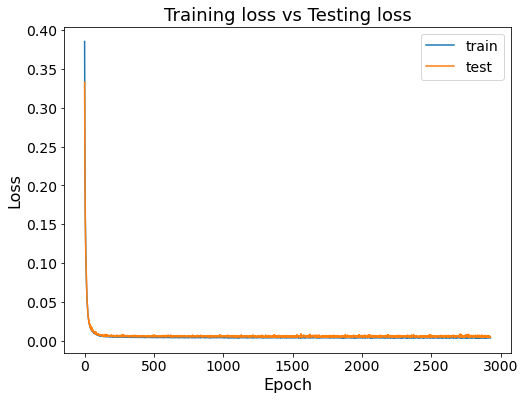

In [31]:
lr = 0.0001
EPOCHS = 6000

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


energy_pararcnn.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
              optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/energy_pararcnn_sc1_4layer_{}h.h5'.format(K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = energy_pararcnn.fit(train_X, train_y,
                              batch_size=512,
                              epochs=EPOCHS,
                              validation_data=(test_X, test_y),
                              verbose=2,
                              shuffle=True,
                              callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [32]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/energy_pararcnn_sc1_4layer_{}h.h5'.format(K))

In [33]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

error = inv_yhat - inv_y
print(error.shape)

inv_y.shape, inv_yhat.shape (6994, 24) (6994, 24)
(6994, 24)


In [34]:
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 3.412
RMSE = 4.601
